<a href="https://colab.research.google.com/github/Mamiglia/challenge/blob/master/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

❕ Add `kaggle.json` API token to files before starting

In [4]:
import os, subprocess

def run(cmd):
    """Helper to execute shell commands with logging."""
    print(f"▶ {cmd}")
    subprocess.run(cmd, shell=True, check=True)

# --- Kaggle setup ---
if not os.path.exists(os.path.expanduser("~/.kaggle/kaggle.json")):
    run("mkdir -p ~/.kaggle && cp kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json")

# --- Kaggle data download (only if missing) ---
if not os.path.exists("data/train"):
    run("kaggle competitions download -c aml-competition -p data")
    run("unzip -qo data/aml-competition.zip -d data")

# --- Clone repositories ---
if not os.path.exists("challenge"):
    run("git clone https://github.com/Mamiglia/challenge.git")
if not os.path.exists("CrossFlow"):
    run("git clone https://github.com/qihao067/CrossFlow.git")

# --- Install dependencies ---
!pip install -q torch torchvision torchaudio
!pip install -q openai-clip scikit-learn opencv-python torchdiffeq \
    beautifulsoup4 open_clip_torch scikit-image cython matplotlib accelerate \
    absl-py ml_collections einops wandb ftfy transformers timm tensorboard pycocotools

In [5]:
import torch, torch.nn as nn, torch.nn.functional as F, numpy as np
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from tqdm import tqdm
import sys, random, logging

# Extend path to local repositories
sys.path.extend(["CrossFlow", "challenge/src"])

# Project imports
from common.utils import load_data, prepare_train_data, generate_submission
from eval.metrics import mrr, recall_at_k, ndcg
from diffusion.flow_matching import ClipLoss
from challenge.src.eval import visualize_retrieval

# Clear existing handlers
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(message)s",
    handlers=[logging.StreamHandler(sys.stdout)]
)

In [6]:
# Configuration dictionary
CFG = {
    "MODEL_PATH": "models/vae_adapter.pth",
    "EPOCHS": 40,
    "BATCH_SIZE": 1024,
    "LR": 1e-3,
    "KLD_WEIGHT": 1e-4,
    "LATENT_DIM": 1536,
    "HIDDEN_DIM": 2048,
    "VALIDATION_MODE": "ir_metrics",  # or "cliploss"
    "MODEL": "vae_adapter",
    "LOSS": "vae_clip",
    "SEED": 42,
    "DEVICE": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

In [7]:
def set_seed(seed=42):
  """Ensure deterministic reproducibility."""
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

set_seed(CFG["SEED"])
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Models

In [8]:
class VAEAdapter(nn.Module):
    """
    A simple VAE-based translator from text embeddings to image embeddings.

    Args:
        input_dim (int): Dimension of the input text embeddings.
        output_dim (int): Dimension of the output image embeddings.
        hidden_dim (int): Hidden layer width.
        latent_dim (int): Latent space dimensionality.
    """
    def __init__(self, input_dim, output_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.GELU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, output_dim)
        )

        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

    def reparameterize(self, mu, logvar):
        """Apply reparameterization trick."""
        return mu + torch.randn_like(mu) * torch.exp(0.5 * logvar)

    def forward(self, x):
        """Forward pass: encode → sample → decode."""
        x = F.normalize(x, dim=-1)
        mu, logvar = self.encoder(x).chunk(2, dim=-1)
        z = self.reparameterize(mu, logvar)
        out = self.decoder(z)
        return F.normalize(out, dim=-1), mu, logvar


def init_weights(m):
    """Kaiming initialization for all Linear layers."""
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

MODEL_REGISTRY = {"vae_adapter": VAEAdapter}


# Loss and Val

In [9]:
"""
Loss and validation are modular, allowing easy swapping during Optuna tuning.
"""

class VAELoss:
    """
    Combines CLIP-style reconstruction with VAE regularization.
    """
    def __init__(self, device=None):
        self.clip = ClipLoss().to(device or CFG["DEVICE"])

    def __call__(self, pred, mu, logvar, y, logit_scale, kld_weight):
        y = F.normalize(y, dim=-1)
        recons = self.clip(image_features=y, text_features=pred, logit_scale=logit_scale)
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
        return recons + kld_weight * kld


@torch.inference_mode()
def validate_ir_metrics(model, val_loader, val_gallery, val_labels):
    """
    Evaluate using the challenge’s official retrieval metrics (MRR, Recall@k, etc.).
    """
    model.eval()
    preds = [model(X.to(CFG["DEVICE"]))[0] for X, _ in tqdm(val_loader, desc="[Val]")]
    preds = torch.cat(preds)
    return evaluate_retrieval(preds, val_gallery.to(CFG["DEVICE"]), val_labels, max_indices=100)


@torch.inference_mode()
def validate_cliploss(model, val_loader, loss_fn, logit_scale):
    """
    Evaluate using internal CLIP-style reconstruction loss.
    """
    model.eval()
    val_loss = 0
    for X, y in tqdm(val_loader, desc="[Val]"):
        X, y = X.to(CFG["DEVICE"]), y.to(CFG["DEVICE"])
        pred, mu, logvar = model(X)
        val_loss += loss_fn(pred, mu, logvar, y, logit_scale).item()
    return {"val_loss": val_loss / len(val_loader)}

LOSS_REGISTRY = {"vae_clip": VAELoss}
VALIDATION_REGISTRY = {"ir_metrics": validate_ir_metrics, "cliploss": validate_cliploss}


# Val

In [10]:
@torch.inference_mode()
def evaluate_retrieval(translated_embd, image_embd, gt_indices, max_indices=99, batch_size=100):
    """
    GPU-safe, fixed version of challenge/src/eval/eval.py.
    """
    if isinstance(translated_embd, np.ndarray):
        translated_embd = torch.from_numpy(translated_embd).float()
    if isinstance(image_embd, np.ndarray):
        image_embd = torch.from_numpy(image_embd).float()

    n_queries = translated_embd.shape[0]
    all_sorted_indices = []

    for start_idx in range(0, n_queries, batch_size):
        batch_slice = slice(start_idx, min(start_idx + batch_size, n_queries))
        batch_translated = translated_embd[batch_slice]

        batch_similarity = batch_translated @ image_embd.T
        batch_indices = batch_similarity.topk(k=max_indices, dim=1, sorted=True).indices.cpu().numpy()
        all_sorted_indices.append(batch_indices)

    sorted_indices = np.concatenate(all_sorted_indices, axis=0)

    metrics = {
        'mrr': mrr,
        'ndcg': ndcg,
        'recall_at_1': lambda preds, gt: recall_at_k(preds, gt, 1),
        'recall_at_3': lambda preds, gt: recall_at_k(preds, gt, 3),
        'recall_at_5': lambda preds, gt: recall_at_k(preds, gt, 5),
        'recall_at_10': lambda preds, gt: recall_at_k(preds, gt, 10),
        'recall_at_50': lambda preds, gt: recall_at_k(preds, gt, 50),
    }

    results = {name: func(sorted_indices, gt_indices) for name, func in metrics.items()}
    return results


# Training

In [11]:
def kld_weight_schedule(step, total_steps, max_weight):
    # cosine increase from 0 → max_weight
    return max_weight * (0.5 - 0.5 * np.cos(np.pi * step / total_steps))

In [12]:
def train_model(model, train_loader, val_loader, val_gallery, val_labels, loss_fn, cfg):
    """
    Train the model.
    """
    device = cfg["DEVICE"]
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg["LR"], weight_decay=1e-4)
    steps_per_epoch = len(train_loader)
    total_steps = steps_per_epoch * cfg["EPOCHS"]
    global_step = 0
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= steps_per_epoch * cfg["EPOCHS"])
    validate = VALIDATION_REGISTRY[cfg["VALIDATION_MODE"]]
    best_metric = 0.0 if cfg["VALIDATION_MODE"] == "ir_metrics" else float("inf")

    for epoch in range(cfg["EPOCHS"]):
        model.train()
        total_loss = 0
        for X, y in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{cfg['EPOCHS']}"):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            pred, mu, logvar = model(X)
            kld_w = kld_weight_schedule(global_step, total_steps, cfg["KLD_WEIGHT"])
            loss = loss_fn(pred, mu, logvar, y, model.logit_scale.exp().clamp(max=100), kld_w)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            global_step += 1

        avg_loss = total_loss / len(train_loader)
        tqdm.write(f"> Epoch {epoch+1}: Avg Loss = {avg_loss:.6f}")

        if cfg["VALIDATION_MODE"] == "ir_metrics":
            val_results = validate(model, val_loader, val_gallery, val_labels)
            metric = val_results["mrr"]
            improve = metric > best_metric
            tqdm.write(f"> MRR = {metric:.4f}, R@1 = {val_results["recall_at_1"]:.4f}, R@5 = {val_results["recall_at_5"]}")
        else:
            val_results = validate(model, val_loader, loss_fn, model.logit_scale.exp().clamp(1, 100))
            metric = val_results["val_loss"]
            improve = metric < best_metric
            tqdm.write(f"> Loss={-metric:.6f}")

        if improve:
            best_metric = metric
            Path(cfg["MODEL_PATH"]).parent.mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), cfg["MODEL_PATH"])
            tqdm.write(f"✓ New best model saved (metric={best_metric:.4f})")

    return best_metric


In [13]:
"""
Prepare training and validation sets, and cache full gallery for MRR computation.
"""
train_data = load_data("data/train/train/train.npz")
X, y, label = prepare_train_data(train_data)

perm = torch.randperm(len(X))
split_idx = int(0.9 * len(X))
mask = torch.zeros(len(X), dtype=torch.bool)
mask[perm[:split_idx]] = True

X_train, X_val = X[mask], X[~mask]
y_train, y_val = y[mask], y[~mask]
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=CFG["BATCH_SIZE"], shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=CFG["BATCH_SIZE"])

img_mask = label[~mask].sum(dim=0) > 0
val_gallery = torch.from_numpy(train_data["images/embeddings"])
val_labels = np.nonzero(train_data["captions/label"][~mask])[1]


(125000,)
Train data: 125000 captions, 125000 images


In [14]:
"""
Build, initialize, and train the selected model.
"""

model = MODEL_REGISTRY[CFG["MODEL"]](X_train.shape[-1], y_train.shape[-1], CFG["HIDDEN_DIM"], CFG["LATENT_DIM"]).to(CFG["DEVICE"])
model.apply(init_weights)

loss_fn = LOSS_REGISTRY[CFG["LOSS"]](device=CFG["DEVICE"])
best_metric = train_model(model, train_loader, val_loader, val_gallery, val_labels, loss_fn, CFG)

logging.info(f"### Best metric: {best_metric:.4f} ###")

[Train] Epoch 1/40: 100%|██████████| 110/110 [00:05<00:00, 19.25it/s]


> Epoch 1: Avg Loss = 3.997147


[Val]: 100%|██████████| 13/13 [00:00<00:00, 118.70it/s]


> MRR = 0.0910, R@1 = 0.0390, R@5 = 0.1252
✓ New best model saved (metric=0.0910)


[Train] Epoch 2/40: 100%|██████████| 110/110 [00:04<00:00, 24.91it/s]


> Epoch 2: Avg Loss = 3.202153


[Val]: 100%|██████████| 13/13 [00:00<00:00, 118.53it/s]


> MRR = 0.1204, R@1 = 0.0564, R@5 = 0.16792
✓ New best model saved (metric=0.1204)


[Train] Epoch 3/40: 100%|██████████| 110/110 [00:04<00:00, 23.26it/s]


> Epoch 3: Avg Loss = 2.785816


[Val]: 100%|██████████| 13/13 [00:00<00:00, 120.87it/s]


> MRR = 0.1467, R@1 = 0.0749, R@5 = 0.20344
✓ New best model saved (metric=0.1467)


[Train] Epoch 4/40: 100%|██████████| 110/110 [00:04<00:00, 24.57it/s]


> Epoch 4: Avg Loss = 2.433725


[Val]: 100%|██████████| 13/13 [00:00<00:00, 119.37it/s]


> MRR = 0.1679, R@1 = 0.0871, R@5 = 0.2384
✓ New best model saved (metric=0.1679)


[Train] Epoch 5/40: 100%|██████████| 110/110 [00:04<00:00, 23.82it/s]


> Epoch 5: Avg Loss = 2.121433


[Val]: 100%|██████████| 13/13 [00:00<00:00, 121.08it/s]


> MRR = 0.1909, R@1 = 0.1043, R@5 = 0.26968
✓ New best model saved (metric=0.1909)


[Train] Epoch 6/40: 100%|██████████| 110/110 [00:04<00:00, 24.28it/s]


> Epoch 6: Avg Loss = 1.835808


[Val]: 100%|██████████| 13/13 [00:00<00:00, 121.27it/s]


> MRR = 0.2083, R@1 = 0.1166, R@5 = 0.2948
✓ New best model saved (metric=0.2083)


[Train] Epoch 7/40: 100%|██████████| 110/110 [00:04<00:00, 23.53it/s]


> Epoch 7: Avg Loss = 1.586083


[Val]: 100%|██████████| 13/13 [00:00<00:00, 120.24it/s]


> MRR = 0.2241, R@1 = 0.1277, R@5 = 0.31616
✓ New best model saved (metric=0.2241)


[Train] Epoch 8/40: 100%|██████████| 110/110 [00:04<00:00, 23.91it/s]


> Epoch 8: Avg Loss = 1.338613


[Val]: 100%|██████████| 13/13 [00:00<00:00, 122.83it/s]


> MRR = 0.2418, R@1 = 0.1418, R@5 = 0.33792
✓ New best model saved (metric=0.2418)


[Train] Epoch 9/40: 100%|██████████| 110/110 [00:04<00:00, 23.43it/s]


> Epoch 9: Avg Loss = 1.114875


[Val]: 100%|██████████| 13/13 [00:00<00:00, 120.61it/s]


> MRR = 0.2539, R@1 = 0.1535, R@5 = 0.35472
✓ New best model saved (metric=0.2539)


[Train] Epoch 10/40: 100%|██████████| 110/110 [00:04<00:00, 23.88it/s]


> Epoch 10: Avg Loss = 0.928767


[Val]: 100%|██████████| 13/13 [00:00<00:00, 50.91it/s]


> MRR = 0.2632, R@1 = 0.1599, R@5 = 0.36696
✓ New best model saved (metric=0.2632)


[Train] Epoch 11/40: 100%|██████████| 110/110 [00:04<00:00, 23.12it/s]


> Epoch 11: Avg Loss = 0.772404


[Val]: 100%|██████████| 13/13 [00:00<00:00, 81.94it/s]


> MRR = 0.2686, R@1 = 0.1622, R@5 = 0.37696
✓ New best model saved (metric=0.2686)


[Train] Epoch 12/40: 100%|██████████| 110/110 [00:04<00:00, 23.92it/s]


> Epoch 12: Avg Loss = 0.629515


[Val]: 100%|██████████| 13/13 [00:00<00:00, 117.48it/s]


> MRR = 0.2794, R@1 = 0.1727, R@5 = 0.39392
✓ New best model saved (metric=0.2794)


[Train] Epoch 13/40: 100%|██████████| 110/110 [00:04<00:00, 23.36it/s]


> Epoch 13: Avg Loss = 0.500889


[Val]: 100%|██████████| 13/13 [00:00<00:00, 85.30it/s]


> MRR = 0.2858, R@1 = 0.1759, R@5 = 0.40536
✓ New best model saved (metric=0.2858)


[Train] Epoch 14/40: 100%|██████████| 110/110 [00:04<00:00, 23.66it/s]


> Epoch 14: Avg Loss = 0.409315


[Val]: 100%|██████████| 13/13 [00:00<00:00, 116.20it/s]


> MRR = 0.2928, R@1 = 0.1842, R@5 = 0.40816
✓ New best model saved (metric=0.2928)


[Train] Epoch 15/40: 100%|██████████| 110/110 [00:04<00:00, 23.43it/s]


> Epoch 15: Avg Loss = 0.345451


[Val]: 100%|██████████| 13/13 [00:00<00:00, 85.34it/s]


> MRR = 0.2988, R@1 = 0.1906, R@5 = 0.41504
✓ New best model saved (metric=0.2988)


[Train] Epoch 16/40: 100%|██████████| 110/110 [00:04<00:00, 23.59it/s]


> Epoch 16: Avg Loss = 0.305674


[Val]: 100%|██████████| 13/13 [00:00<00:00, 114.93it/s]


> MRR = 0.3012, R@1 = 0.1932, R@5 = 0.41736
✓ New best model saved (metric=0.3012)


[Train] Epoch 17/40: 100%|██████████| 110/110 [00:04<00:00, 23.82it/s]


> Epoch 17: Avg Loss = 0.275444


[Val]: 100%|██████████| 13/13 [00:00<00:00, 81.42it/s]


> MRR = 0.3013, R@1 = 0.1919, R@5 = 0.42024
✓ New best model saved (metric=0.3013)


[Train] Epoch 18/40: 100%|██████████| 110/110 [00:04<00:00, 23.28it/s]


> Epoch 18: Avg Loss = 0.253804


[Val]: 100%|██████████| 13/13 [00:00<00:00, 51.18it/s]


> MRR = 0.3045, R@1 = 0.1963, R@5 = 0.42304
✓ New best model saved (metric=0.3045)


[Train] Epoch 19/40: 100%|██████████| 110/110 [00:04<00:00, 23.84it/s]


> Epoch 19: Avg Loss = 0.239066


[Val]: 100%|██████████| 13/13 [00:00<00:00, 118.61it/s]


> MRR = 0.3047, R@1 = 0.1935, R@5 = 0.42512
✓ New best model saved (metric=0.3047)


[Train] Epoch 20/40: 100%|██████████| 110/110 [00:04<00:00, 23.29it/s]


> Epoch 20: Avg Loss = 0.228656


[Val]: 100%|██████████| 13/13 [00:00<00:00, 117.73it/s]


> MRR = 0.3068, R@1 = 0.1989, R@5 = 0.42344
✓ New best model saved (metric=0.3068)


[Train] Epoch 21/40: 100%|██████████| 110/110 [00:04<00:00, 23.88it/s]


> Epoch 21: Avg Loss = 0.219651


[Val]: 100%|██████████| 13/13 [00:00<00:00, 117.97it/s]


> MRR = 0.3058, R@1 = 0.1988, R@5 = 0.4208


[Train] Epoch 22/40: 100%|██████████| 110/110 [00:04<00:00, 23.11it/s]


> Epoch 22: Avg Loss = 0.215341


[Val]: 100%|██████████| 13/13 [00:00<00:00, 120.21it/s]


> MRR = 0.3084, R@1 = 0.2017, R@5 = 0.42464
✓ New best model saved (metric=0.3084)


[Train] Epoch 23/40: 100%|██████████| 110/110 [00:04<00:00, 23.92it/s]


> Epoch 23: Avg Loss = 0.207237


[Val]: 100%|██████████| 13/13 [00:00<00:00, 102.22it/s]


> MRR = 0.3086, R@1 = 0.2001, R@5 = 0.42528
✓ New best model saved (metric=0.3086)


[Train] Epoch 24/40: 100%|██████████| 110/110 [00:04<00:00, 22.87it/s]


> Epoch 24: Avg Loss = 0.201888


[Val]: 100%|██████████| 13/13 [00:00<00:00, 117.75it/s]


> MRR = 0.3095, R@1 = 0.2024, R@5 = 0.42656
✓ New best model saved (metric=0.3095)


[Train] Epoch 25/40: 100%|██████████| 110/110 [00:04<00:00, 23.88it/s]


> Epoch 25: Avg Loss = 0.199446


[Val]: 100%|██████████| 13/13 [00:00<00:00, 119.32it/s]


> MRR = 0.3078, R@1 = 0.1998, R@5 = 0.42488


[Train] Epoch 26/40: 100%|██████████| 110/110 [00:04<00:00, 22.36it/s]


> Epoch 26: Avg Loss = 0.194608


[Val]: 100%|██████████| 13/13 [00:00<00:00, 117.95it/s]


> MRR = 0.3091, R@1 = 0.2014, R@5 = 0.4264


[Train] Epoch 27/40: 100%|██████████| 110/110 [00:04<00:00, 23.94it/s]


> Epoch 27: Avg Loss = 0.191174


[Val]: 100%|██████████| 13/13 [00:00<00:00, 105.80it/s]


> MRR = 0.3119, R@1 = 0.2067, R@5 = 0.42304
✓ New best model saved (metric=0.3119)


[Train] Epoch 28/40: 100%|██████████| 110/110 [00:04<00:00, 22.80it/s]


> Epoch 28: Avg Loss = 0.188756


[Val]: 100%|██████████| 13/13 [00:00<00:00, 113.93it/s]


> MRR = 0.3099, R@1 = 0.2030, R@5 = 0.42408


[Train] Epoch 29/40: 100%|██████████| 110/110 [00:04<00:00, 23.64it/s]


> Epoch 29: Avg Loss = 0.186522


[Val]: 100%|██████████| 13/13 [00:00<00:00, 114.32it/s]


> MRR = 0.3115, R@1 = 0.2046, R@5 = 0.4268


[Train] Epoch 30/40: 100%|██████████| 110/110 [00:04<00:00, 22.84it/s]


> Epoch 30: Avg Loss = 0.185413


[Val]: 100%|██████████| 13/13 [00:00<00:00, 81.26it/s]


> MRR = 0.3128, R@1 = 0.2067, R@5 = 0.42592
✓ New best model saved (metric=0.3128)


[Train] Epoch 31/40: 100%|██████████| 110/110 [00:04<00:00, 23.56it/s]


> Epoch 31: Avg Loss = 0.182914


[Val]: 100%|██████████| 13/13 [00:00<00:00, 116.59it/s]


> MRR = 0.3120, R@1 = 0.2041, R@5 = 0.42976


[Train] Epoch 32/40: 100%|██████████| 110/110 [00:04<00:00, 23.24it/s]


> Epoch 32: Avg Loss = 0.183484


[Val]: 100%|██████████| 13/13 [00:00<00:00, 81.50it/s]


> MRR = 0.3120, R@1 = 0.2046, R@5 = 0.42656


[Train] Epoch 33/40: 100%|██████████| 110/110 [00:04<00:00, 23.89it/s]


> Epoch 33: Avg Loss = 0.180883


[Val]: 100%|██████████| 13/13 [00:00<00:00, 50.58it/s]


> MRR = 0.3118, R@1 = 0.2036, R@5 = 0.43024


[Train] Epoch 34/40: 100%|██████████| 110/110 [00:04<00:00, 23.72it/s]


> Epoch 34: Avg Loss = 0.179142


[Val]: 100%|██████████| 13/13 [00:00<00:00, 86.74it/s]


> MRR = 0.3107, R@1 = 0.2036, R@5 = 0.42592


[Train] Epoch 35/40: 100%|██████████| 110/110 [00:04<00:00, 23.57it/s]


> Epoch 35: Avg Loss = 0.181991


[Val]: 100%|██████████| 13/13 [00:00<00:00, 115.21it/s]


> MRR = 0.3105, R@1 = 0.2029, R@5 = 0.4248


[Train] Epoch 36/40: 100%|██████████| 110/110 [00:04<00:00, 23.68it/s]


> Epoch 36: Avg Loss = 0.178826


[Val]: 100%|██████████| 13/13 [00:00<00:00, 115.98it/s]


> MRR = 0.3108, R@1 = 0.2032, R@5 = 0.42696


[Train] Epoch 37/40: 100%|██████████| 110/110 [00:04<00:00, 23.32it/s]


> Epoch 37: Avg Loss = 0.179915


[Val]: 100%|██████████| 13/13 [00:00<00:00, 115.59it/s]


> MRR = 0.3117, R@1 = 0.2047, R@5 = 0.42712


[Train] Epoch 38/40: 100%|██████████| 110/110 [00:04<00:00, 23.87it/s]


> Epoch 38: Avg Loss = 0.179641


[Val]: 100%|██████████| 13/13 [00:00<00:00, 117.53it/s]


> MRR = 0.3108, R@1 = 0.2037, R@5 = 0.42752


[Train] Epoch 39/40: 100%|██████████| 110/110 [00:04<00:00, 22.95it/s]


> Epoch 39: Avg Loss = 0.178281


[Val]: 100%|██████████| 13/13 [00:00<00:00, 115.51it/s]


> MRR = 0.3100, R@1 = 0.2029, R@5 = 0.4244


[Train] Epoch 40/40: 100%|██████████| 110/110 [00:04<00:00, 23.88it/s]


> Epoch 40: Avg Loss = 0.179968


[Val]: 100%|██████████| 13/13 [00:00<00:00, 117.83it/s]


> MRR = 0.3119, R@1 = 0.2066, R@5 = 0.4252
### Best metric: 0.3128 ###


## Evaluation

### Visualize

/content/challenge/src/eval/visualize.py:27: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4421.)
  similarities = (image_embeddings @ pred_embeddings.T).squeeze().numpy()


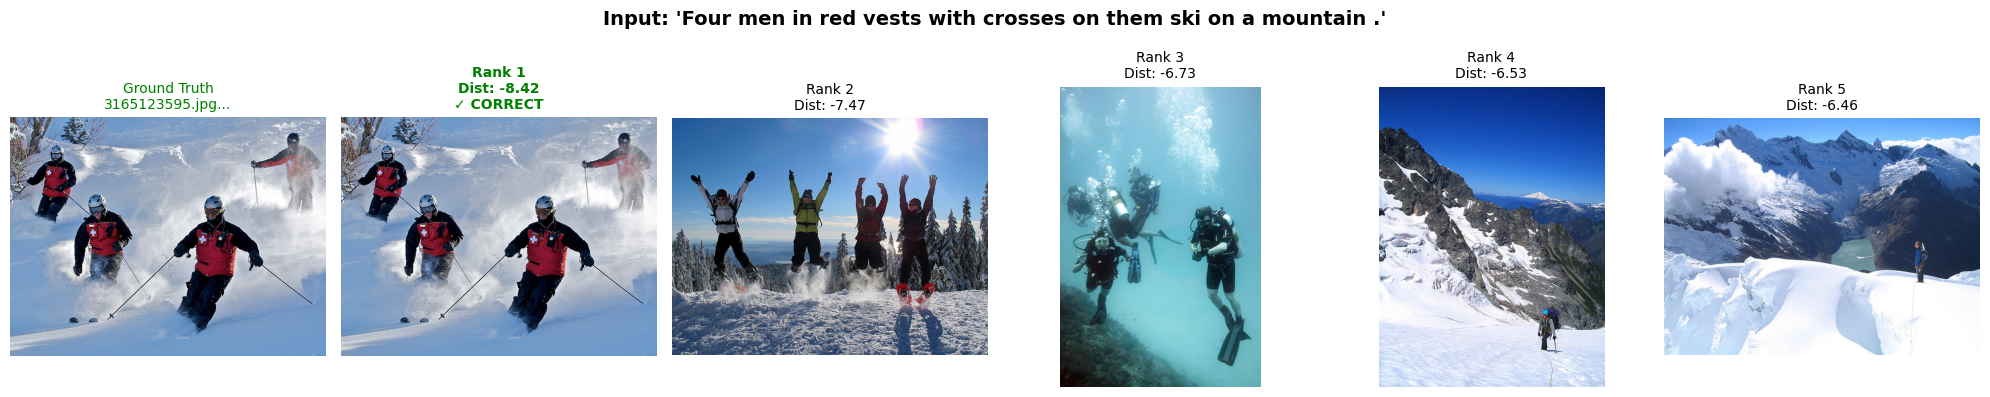

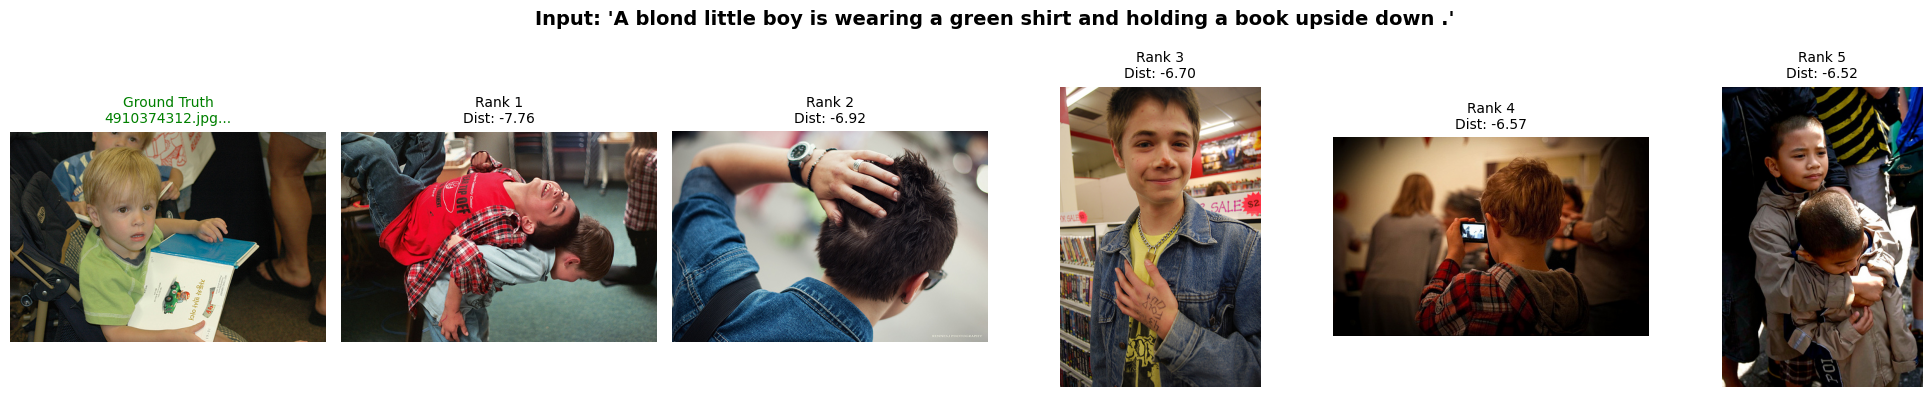

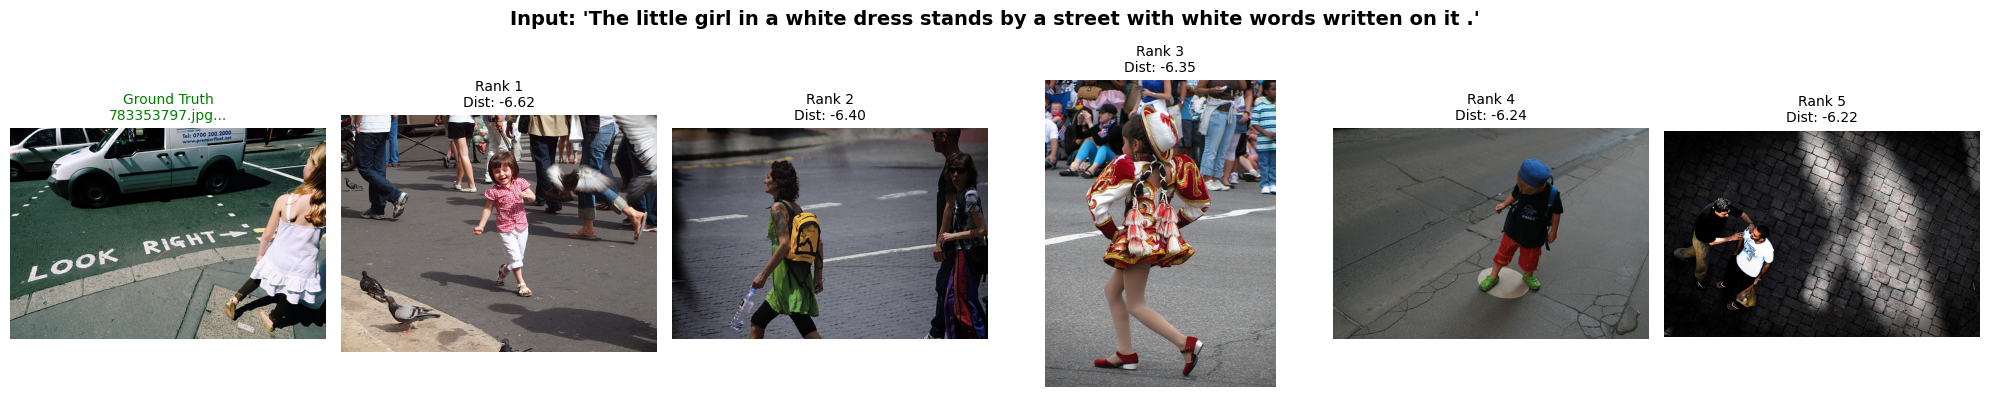

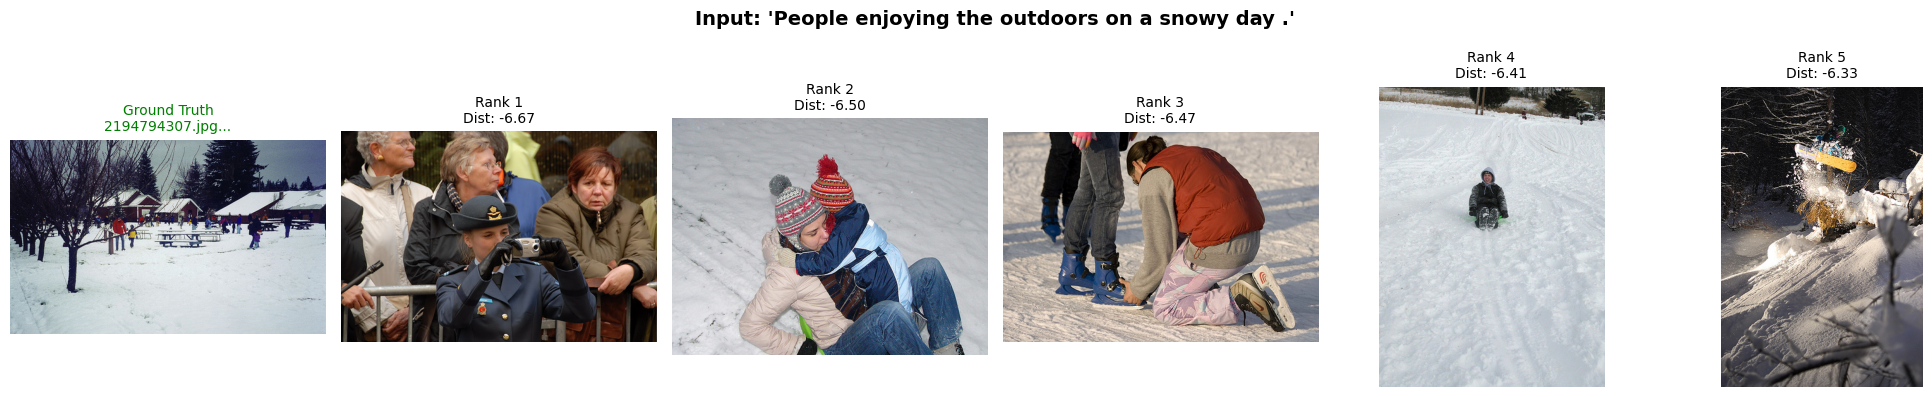

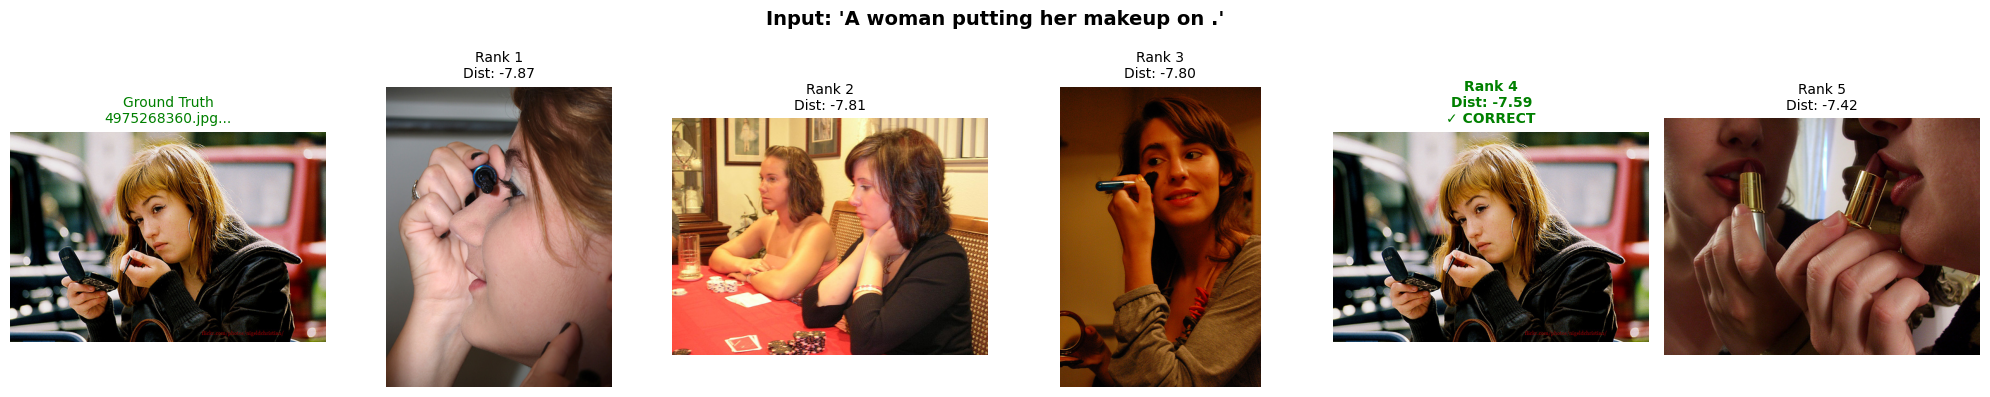

In [15]:
"""
Visualize top retrievals on the validation set for qualitative analysis.
"""

val_texts = train_data["captions/text"][~mask]
val_img_names = train_data["images/names"][img_mask]
val_img_embeds = torch.from_numpy(train_data["images/embeddings"][img_mask])
val_gt = np.nonzero(train_data["captions/label"][~mask][:, img_mask])[1]

model.eval()
for i in range(5):
    idx = np.random.randint(0, len(val_texts))
    caption = val_texts[idx]
    gt = val_gt[idx]
    with torch.no_grad():
        pred, _, _ = model(X_val[idx].unsqueeze(0).to(CFG["DEVICE"]))
        pred = pred.squeeze(0).cpu()
    visualize_retrieval(pred, gt, val_img_names, caption, val_img_embeds, k=5, dataset_path="data/train/train")


## Submission

In [16]:
"""
Generate predictions for the test set and export the Kaggle submission file.
"""

test_data = load_data("data/test/test/test.clean.npz")
test_emb = torch.from_numpy(test_data["captions/embeddings"]).float().to(CFG["DEVICE"])

model.load_state_dict(torch.load(CFG["MODEL_PATH"]))
model.eval()

with torch.no_grad():
    pred, _, _ = model(test_emb)

generate_submission(test_data["captions/ids"], pred.cpu(), "submission_vae.csv")
logging.info(f"Submission saved | Model saved to {CFG['MODEL_PATH']}")


Submission saved | Model saved to models/vae_adapter.pth
